In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev

warnings.filterwarnings('ignore')

# Simulated Thermal DB

In [2]:
#################################
# Make test data
# Define the structure of the data
#################################

columns = [

    "year", "month", "day", "hour", "Study_Site",

    "Burrow_mean_Temperature", "Burrow_stddev_Temperature",

    "Open_mean_Temperature", "Open_stddev_Temperature",

    "Shrub_mean_Temperature", "Shrub_stddev_Temperature",

    "DateTime", "Mean_StdDev"

]

num_rows = 8760  # Number of rows in the dataset

data = {

    "year": [2025] * num_rows,

    "month": [1] * num_rows,

    "day": [1] * num_rows,

    "hour": list(range(24)) * (num_rows // 24) + list(range(num_rows % 24)),  # Repeat hours for multiple days

    "Study_Site": ["Test_Site"] * num_rows,

    "Burrow_mean_Temperature": [25] * num_rows,

    "Burrow_stddev_Temperature": [1] * num_rows,

    "Open_mean_Temperature": [25] * num_rows,

    "Open_stddev_Temperature": [1] * num_rows,

    "Shrub_mean_Temperature": [25] * num_rows,

    "Shrub_stddev_Temperature": [1] * num_rows,

    "DateTime": pd.date_range(start="2025-01-01", periods=num_rows, freq="H"),

    "Mean_StdDev": [1] * num_rows,

}



# Ensure all columns have the same length

for key, value in data.items():

    if len(value) != num_rows:

        print(f"Column {key} length mismatch: {len(value)} vs {num_rows}")



# Create the DataFrame

df = pd.DataFrame(data)

output_path = "/home/mremington/Documents/therma_sim/therma_sim/tests/Data/thermal_db.csv"

df.to_csv(output_path, index=False)


# Empirical Thermal DB

In [2]:
otm_fp = '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Main_Database.csv'
otm_data = pd.read_csv(otm_fp)
spark = SparkSession.builder.appName("PandasToSparkPivot").getOrCreate()
spark_df = spark.createDataFrame(otm_data)
# going to remove year and see how it does 05/12/25
# Pivot the Spark DataFrame
otm_data = spark_df.groupBy('Study_Site',
       'Study_Site_Code','month','day','hour').pivot("Microhabitat").agg(
    mean("Temperature").alias("mean_Temperature"),
    stddev("Temperature").alias("stddev_Temperature")
)


# # Display the pivoted Spark DataFrame
otm_data = otm_data.toPandas()
otm_data = otm_data.sort_values(by=['Study_Site', 'month', 'day', 'hour'], ascending=True).reset_index(drop=True)
otm_data['datetime'] = pd.to_datetime({
    'year': 2000,
    'month': otm_data['month'],
    'day': otm_data['day'],
    'hour': otm_data['hour']
})
otm_data['mdh'] = otm_data['month'].astype(str).str.zfill(2) + '-' + \
                  otm_data['day'].astype(str).str.zfill(2) + ' ' + \
                  otm_data['hour'].astype(str).str.zfill(2) + ':00'

# #otm_data.drop(columns=['Air_mean_Temperature', 'Air_stddev_Temperature'], inplace=True)
# columns_to_check = ['Burrow_mean_Temperature', 'Open_mean_Temperature', 'Shrub_mean_Temperature']
# #otm_data = otm_data.dropna(subset=columns_to_check)
# # Calculate the mean of standard deviation grouped by DateTime ignoring the Study_Site
# mean_stddev_by_date = otm_data.groupby(otm_data['mdh'])['Burrow_stddev_Temperature'].mean().reset_index()
# mean_stddev_by_date.columns = ['mdh', 'Mean_StdDev']


# # # Merge the mean stddev back to the original dataframe
# # otm_data['Date'] = otm_data['DateTime'].dt.date
# otm_data = pd.merge(otm_data, mean_stddev_by_date, on='mdh', how='left')
# # # Replace the standard deviation for the Nebraska study site
# #otm_data.loc[otm_data['Study_Site'] == 'Nebraska', 'Burrow_stddev_Temperature'] = otm_data['Mean_StdDev']

# # # Drop the helper columns
# #otm_data.drop(columns=['Date', 'Mean_StdDev','Mean_StdDev_x','Mean_StdDev_y'], inplace=True)
otm_data= otm_data.drop(['Grass_mean_Temperature', 'Grass_stddev_Temperature', 'Unknown_mean_Temperature', 'Unknown_mean_Temperature', 'Unknown_stddev_Temperature'], axis=1)
otm_data.head()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/14 17:57:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/14 17:58:19 WARN TaskSetManager: Stage 0 contains a task of very large size (5601 KiB). The maximum recommended task size is 1000 KiB.
25/05/14 17:58:23 WARN TaskSetManager: Stage 8 contains a task of very large size (5601 KiB). The maximum recommended task size is 1000 KiB.


,Study_Site,Study_Site_Code,month,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,datetime,mdh
0,Canada,1,1,1,0,-5.995,6.379517,-1.9160,0.797905,-4.585400,2.029146,-4.4866,3.131550,2000-01-01 00:00:00,01-01 00:00
1,Canada,1,1,1,1,0.026,NaN,-1.4698,0.337789,-1.654333,0.264772,-1.4875,0.027577,2000-01-01 01:00:00,01-01 01:00
2,Canada,1,1,1,2,-4.738,6.025964,-1.6644,0.714625,-3.682200,2.788074,-3.6818,3.195769,2000-01-01 02:00:00,01-01 02:00
3,Canada,1,1,1,3,-3.984,6.382346,-1.4632,0.786630,-2.979400,3.212456,-3.3798,3.186982,2000-01-01 03:00:00,01-01 03:00
4,Canada,1,1,1,4,-3.733,6.027378,-1.0609,0.999010,-2.377600,3.519416,-3.0784,3.506362,2000-01-01 04:00:00,01-01 04:00


In [36]:
# unique_combinations = otm_data[['Study_Site', 'Microhabitat']].drop_duplicates()
# print(unique_combinations)

In [ ]:
# otm_data['Date'] = pd.to_datetime(otm_data['Date'])

# # Get index of the minimum date for each Study_Site
# min_date_idx = otm_data.groupby('Study_Site')['Date'].idxmin()

# # Get the full rows corresponding to those indexes
# min_date_rows = otm_data.loc[min_date_idx]

# min_date_rows.head()


,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Study_Site_Code
0,2022-06-17 23:00:01,C,17.663,2022,6,17,23,0,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,Spring,WaningGibbous,Night,Summer,1
158066,2022-05-29 20:20:01,C,22.069,2022,5,29,20,20,Nebraska,Shrub,OTM10,OTM10_NE_Shrub_22_23.csv,Spring,WaningCrescent,Night,Spring,2
416971,2021-06-14 18:30:01,C,19.554,2021,6,14,18,30,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,Spring,Noon,Night,Summer,3


In [6]:
nan_microhabitat_rows = otm_data[otm_data['Microhabitat'].isna()]
nan_microhabitat_rows.head()#['file_name'].unique()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Study_Site_Code


In [39]:
otm_data.columns

Index(['Study_Site', 'Study_Site_Code', 'month', 'day', 'hour',
       'Air_mean_Temperature', 'Air_stddev_Temperature',
       'Burrow_mean_Temperature', 'Burrow_stddev_Temperature',
       'Open_mean_Temperature', 'Open_stddev_Temperature',
       'Shrub_mean_Temperature', 'Shrub_stddev_Temperature', 'datetime',
       'mdh'],
      dtype='object')

# Visualize

In [37]:
otm_data[otm_data['Open_mean_Temperature'].isna()].head()

,Study_Site,Study_Site_Code,month,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,datetime,mdh
1419,Canada,1,2,29,3,NaN,NaN,-3.992,NaN,NaN,NaN,NaN,NaN,2000-02-29 03:00:00,02-29 03:00
1426,Canada,1,2,29,10,NaN,NaN,-3.489,NaN,NaN,NaN,NaN,NaN,2000-02-29 10:00:00,02-29 10:00
1433,Canada,1,2,29,17,NaN,NaN,0.535,NaN,NaN,NaN,NaN,NaN,2000-02-29 17:00:00,02-29 17:00
3572,Canada,1,5,31,0,NaN,NaN,15.591,NaN,NaN,NaN,NaN,NaN,2000-05-31 00:00:00,05-31 00:00
3579,Canada,1,5,31,7,NaN,NaN,16.092,NaN,NaN,NaN,NaN,NaN,2000-05-31 07:00:00,05-31 07:00


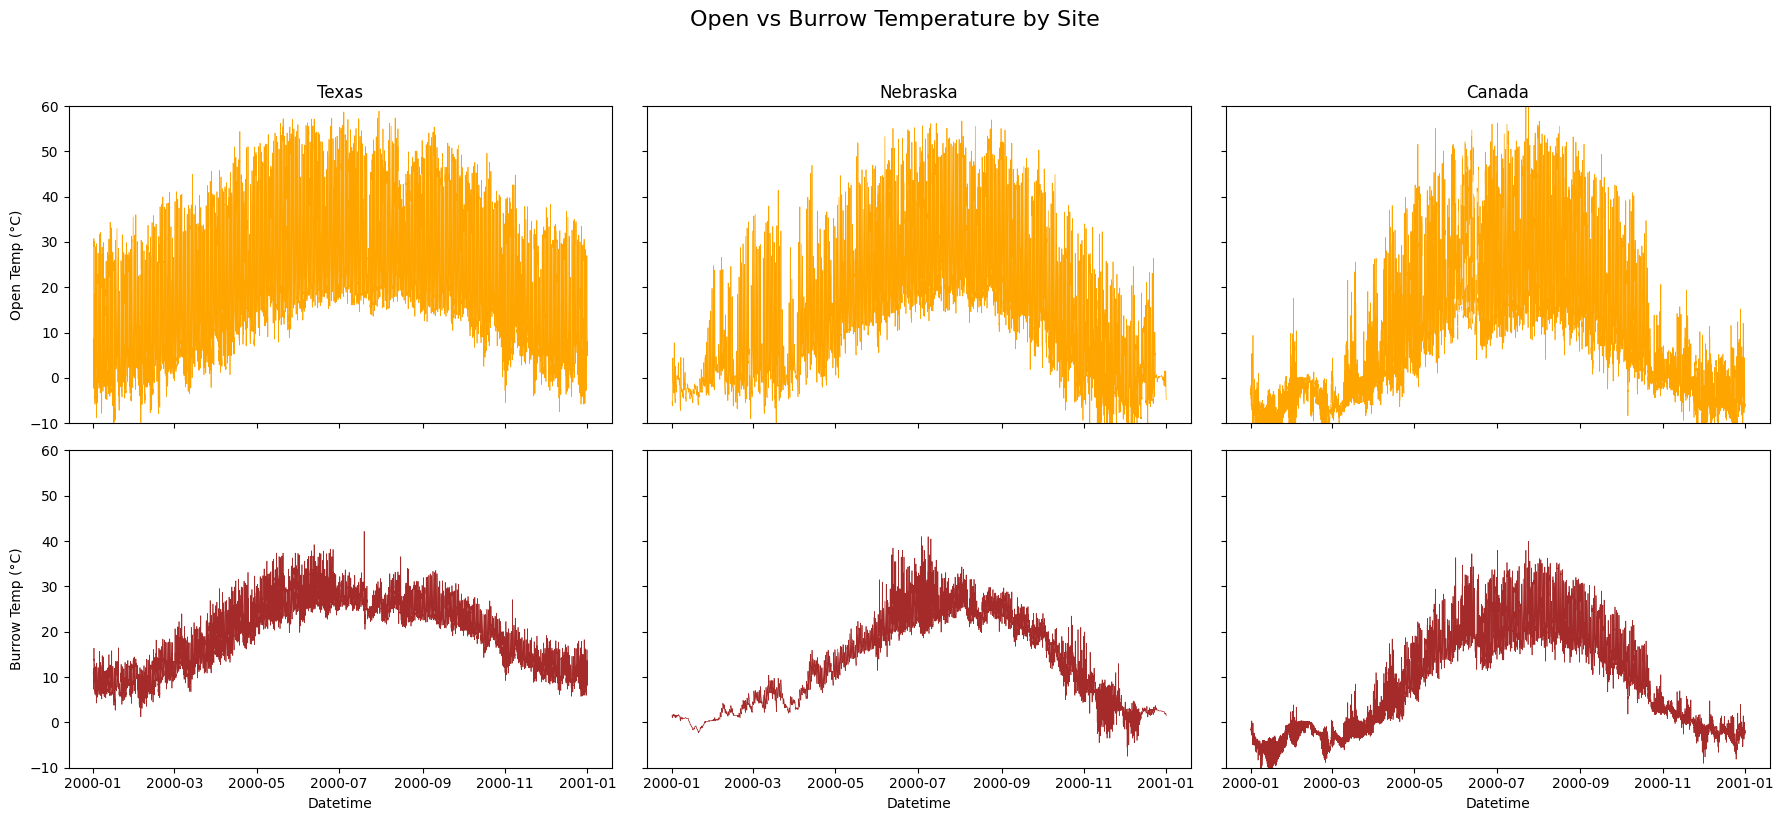

In [4]:

sites = ['Texas', 'Nebraska', 'Canada']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True, sharey='row')

# Titles and labels
for col, site in enumerate(sites):
    site_data = otm_data[otm_data['Study_Site'] == site]
    
    # Top row: Open mean temperature
    axes[0, col].plot(site_data['datetime'], site_data['Open_mean_Temperature'], color='orange', linewidth=0.5)
    axes[0, col].set_title(site)
    axes[0, col].set_ylim(-10, 60)
    if col == 0:
        axes[0, col].set_ylabel('Open Temp (°C)')

    # Bottom row: Burrow mean temperature
    axes[1, col].plot(site_data['datetime'], site_data['Burrow_mean_Temperature'], color='brown', linewidth=0.5)
    if col == 0:
        axes[1, col].set_ylabel('Burrow Temp (°C)')
    axes[1, col].set_xlabel('Datetime')
    axes[1, col].set_ylim(-10, 60)
    

# Formatting
plt.tight_layout()
plt.suptitle('Open vs Burrow Temperature by Site', fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# filtered_df['Burrow_stddev_Temperature'].quantile(.75)

#0.891
#2.939

2.9393610983794862

[Text(0.5, 1.0, 'Open: Mean Temp')]

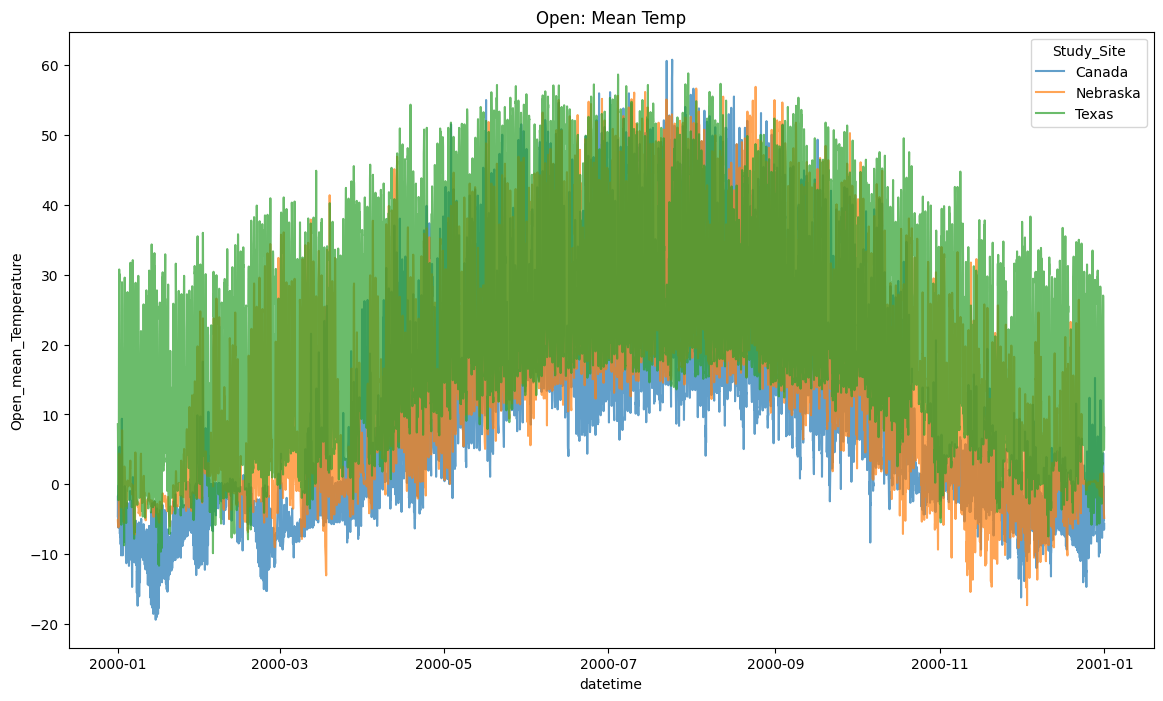

In [46]:
plt.figure(figsize=(14, 8))
column = 'Open_mean_Temperature'
label = column.split('_')[0] + ': Mean Temp'
sns.lineplot(data=otm_data, x='datetime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [54]:
otm_data.head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
0,2022,6,17,23,Canada,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00
1,2022,6,18,0,Canada,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00
2,2022,6,18,1,Canada,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00
3,2022,6,18,2,Canada,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00
4,2022,6,18,3,Canada,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00


In [ ]:
# Fill gaps and shift data
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the time series with only one sensor
model = ARIMA(otm_data['Burrow_mean_Temperature'], order=(1, 0, 0))  # AR(1) model
model_fit = model.fit()

# Use the residuals to estimate the standard deviation
estimated_stddev = np.std(model_fit.resid)
print(estimated_stddev)

1.3017814948015922


[Text(0.5, 1.0, 'Burrow Mean Temp')]

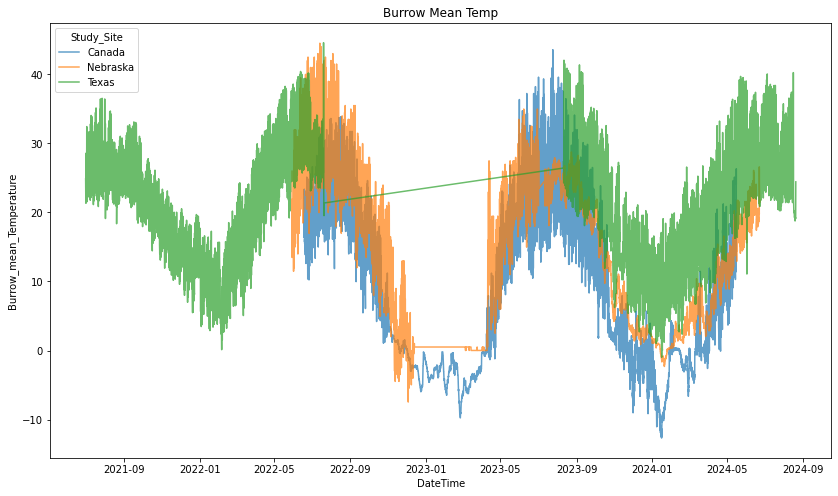

In [39]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=otm_data, x='DateTime', y='Burrow_mean_Temperature', hue='Study_Site', alpha=0.7).set(title='Burrow Mean Temp')

In [12]:
nan_microhabitat_rows = otm_data[otm_data['Burrow_stddev_Temperature'].isna()]
nan_microhabitat_rows.head()
#plt.plot(otm_data['DateTime'], nan_microhabitat_rows['Burrow_stddev_Temperature'], label='Burrow')

,year,month,day,hour,Study_Site,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Grass_mean_Temperature,Grass_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,Unknown_mean_Temperature,Unknown_stddev_Temperature,DateTime,Mean_StdDev
7140,2023,5,31,0,Canada,NaN,NaN,15.591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31 00:00:00,NaN
7147,2023,5,31,7,Canada,NaN,NaN,16.092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31 07:00:00,NaN
7154,2023,5,31,14,Canada,NaN,NaN,17.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31 14:00:00,NaN
7161,2023,5,31,21,Canada,NaN,NaN,17.595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31 21:00:00,NaN
7168,2023,6,1,4,Canada,NaN,NaN,17.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-01 04:00:00,NaN


Aggregate to a year

In [55]:
otm_data.head()

,Study_Site,Study_Site_Code,month,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,mdh
datetime,,,,,,,,,,,,,,
2000-01-01 00:00:00,Canada,1,1,1,0,-5.995,6.379517,-1.9160,0.797905,-4.585400,2.029146,-4.4866,3.131550,01-01 00:00
2000-01-01 01:00:00,Canada,1,1,1,1,0.026,NaN,-1.4698,0.337789,-1.654333,0.264772,-1.4875,0.027577,01-01 01:00
2000-01-01 02:00:00,Canada,1,1,1,2,-4.738,6.025964,-1.6644,0.714625,-3.682200,2.788074,-3.6818,3.195769,01-01 02:00
2000-01-01 03:00:00,Canada,1,1,1,3,-3.984,6.382346,-1.4632,0.786630,-2.979400,3.212456,-3.3798,3.186982,01-01 03:00
2000-01-01 04:00:00,Canada,1,1,1,4,-3.733,6.027378,-1.0609,0.999010,-2.377600,3.519416,-3.0784,3.506362,01-01 04:00


# Interpolate data

In [3]:
from scipy.interpolate import Akima1DInterpolator
# Ensure datetime is datetime

otm_data = otm_data.set_index('datetime')

# Columns to interpolate
columns_to_interpolate = [
    "Air_mean_Temperature", "Air_stddev_Temperature",
    "Burrow_mean_Temperature", "Burrow_stddev_Temperature",
    "Open_mean_Temperature", "Open_stddev_Temperature"
]

# Group and process
resampled_list = []

for site, group in otm_data.groupby("Study_Site"):
    # Keep only numeric columns (drop object columns like Study_Site, etc.)
    numeric_group = group.select_dtypes(include='number')

    # Resample just the numeric data
    group_resampled = numeric_group.resample("60T").mean()

    # Interpolate each desired column using Akima
    for col in columns_to_interpolate:
        non_nan = group_resampled[col].dropna()
        if len(non_nan) > 1:
            x = non_nan.index.astype('int64')  # nanoseconds since epoch
            y = non_nan.values
            interpolator = Akima1DInterpolator(x, y)

            x_full = group_resampled.index.astype('int64')
            interpolated_vals = interpolator(x_full)
            group_resampled[col] = interpolated_vals

    # Restore Study_Site column and append
    group_resampled["Study_Site"] = site
    resampled_list.append(group_resampled)

# Combine and reset index
resampled_therma_df = pd.concat(resampled_list).reset_index()

# Reconstruct date parts if needed
resampled_therma_df["year"] = resampled_therma_df["datetime"].dt.year
resampled_therma_df["month"] = resampled_therma_df["datetime"].dt.month
resampled_therma_df["day"] = resampled_therma_df["datetime"].dt.day
resampled_therma_df["hour"] = resampled_therma_df["datetime"].dt.hour

In [4]:
resampled_therma_df.head()

,datetime,Study_Site_Code,month,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,Study_Site,year
0,2000-01-01 00:00:00,1.0,1,1,0,-5.995,6.379517,-1.9160,0.797905,-4.585400,2.029146,-4.4866,3.131550,Canada,2000
1,2000-01-01 01:00:00,1.0,1,1,1,0.026,6.078993,-1.4698,0.337789,-1.654333,0.264772,-1.4875,0.027577,Canada,2000
2,2000-01-01 02:00:00,1.0,1,1,2,-4.738,6.025964,-1.6644,0.714625,-3.682200,2.788074,-3.6818,3.195769,Canada,2000
3,2000-01-01 03:00:00,1.0,1,1,3,-3.984,6.382346,-1.4632,0.786630,-2.979400,3.212456,-3.3798,3.186982,Canada,2000
4,2000-01-01 04:00:00,1.0,1,1,4,-3.733,6.027378,-1.0609,0.999010,-2.377600,3.519416,-3.0784,3.506362,Canada,2000


[Text(0.5, 1.0, 'Burrow: Mean Temp')]

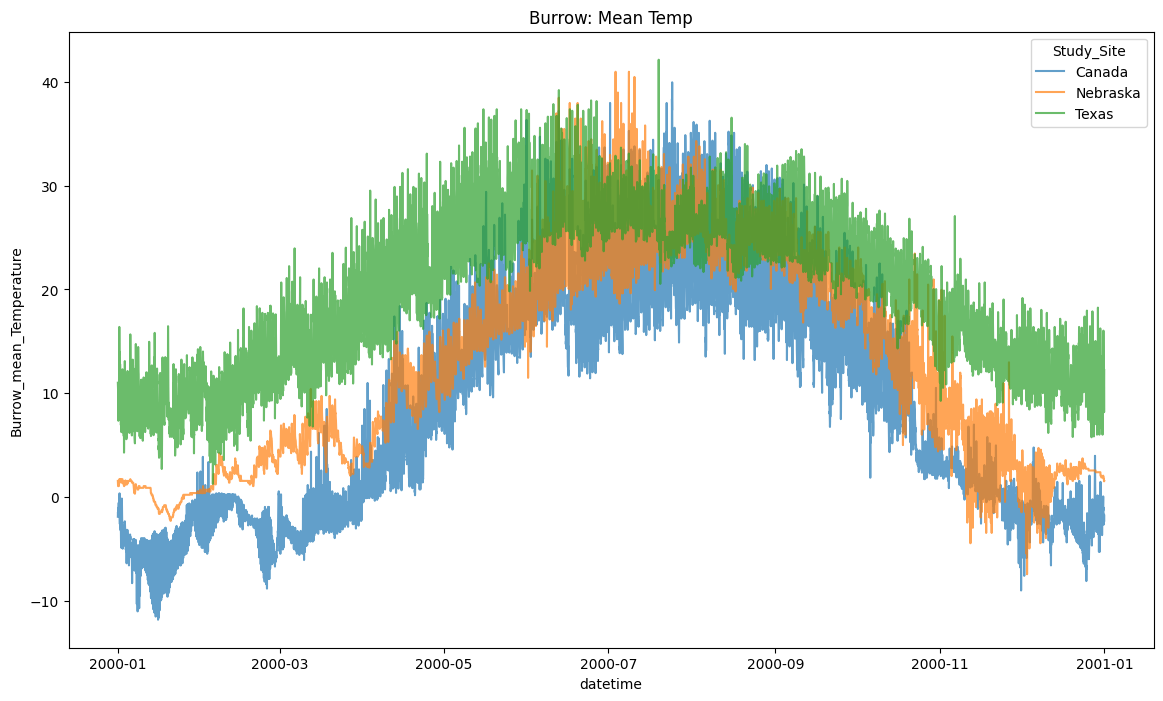

In [5]:
plt.figure(figsize=(14, 8))
column = 'Burrow_mean_Temperature'
label = column.split('_')[0] + ': Mean Temp'
sns.lineplot(data=resampled_therma_df, x='datetime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [ ]:
## Get only last year OLD CODE

# resampled_therma_df['DateTime'] = pd.to_datetime(resampled_therma_df['DateTime'])

# # Create an empty DataFrame for the filtered results
# filtered_data = pd.DataFrame()

# # Process each study site independently
# for site, site_df in resampled_therma_df.groupby('Study_Site'):
#     # Sort the dataset by DateTime to ensure proper indexing
#     site_df = site_df.sort_values(by="DateTime").reset_index(drop=True)
    
#     # Get the index of the latest timestamp
#     latest_idx = site_df.index[-1]  # Last row index
    
#     # Calculate the starting index for the last 365 days
#     start_idx = max(0, latest_idx - (24 * 365))  # Ensures we don't go below index 0

#     # Slice the DataFrame to get the last 365 days of data
#     site_filtered = site_df.iloc[start_idx:]

#     # Append results to the final DataFrame
#     filtered_data = pd.concat([filtered_data, site_filtered])

In [61]:
# plt.figure(figsize=(14, 8))
# column = 'Open_mean_Temperature'
# label = column.split('_')[0] + ': Mean Temp'
# sns.lineplot(data=filtered_data, x='DateTime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [6]:
# Remove leap year
resampled_therma_df = resampled_therma_df[~((resampled_therma_df.month == 2) & (resampled_therma_df.day == 29))]

canada_data = resampled_therma_df[resampled_therma_df['Study_Site'] == 'Canada']
nebraska_data = resampled_therma_df[resampled_therma_df['Study_Site'] == 'Nebraska']
texas_data = resampled_therma_df[resampled_therma_df['Study_Site'] == 'Texas']
print(len(canada_data), len(nebraska_data), len(texas_data))

8760 8760 8760


In [ ]:
# Check for duplicates
duplicates = canada_data[canada_data.duplicated()]
# Sort and convert to strings
unique_times = sorted(canada_data['datetime'].unique())
unique_strs = [str(ts) for ts in unique_times]

# Write to file
with open("canada_unique_datetimes.txt", "w") as f:
    for line in unique_strs:
        f.write(f"{line}\n")


In [8]:
num_years = 6

for site in ['Canada', 'Nebraska', 'Texas']:
    site_df = resampled_therma_df[resampled_therma_df['Study_Site'] == site].copy()

    # Ensure datetime format
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    site_df['month'] = site_df['datetime'].dt.month
    site_df['year'] = site_df['datetime'].dt.year

    # Shift year if before June
    site_df.loc[site_df['month'] < 6, 'year'] += 1

    # Replace year in datetime
    site_df['datetime'] = site_df.apply(
        lambda row: row['datetime'].replace(year=row['year']), axis=1
    )
    # Add static climate shift scenarios
    site_df['open_plus_1'] = site_df['Open_mean_Temperature'] + 1
    site_df['open_plus_2'] = site_df['Open_mean_Temperature'] + 2
    site_df['open_plus_3'] = site_df['Open_mean_Temperature'] + 3

    site_df['burrow_plus_1'] = site_df['Burrow_mean_Temperature'] + 1
    site_df['burrow_plus_2'] = site_df['Burrow_mean_Temperature'] + 2
    site_df['burrow_plus_3'] = site_df['Burrow_mean_Temperature'] + 3

    # Now repeat over 16 years
    repeated_df = pd.DataFrame()

    for i in range(num_years):
        temp_df = site_df.copy()
        temp_df['year'] += i
        temp_df['datetime'] += pd.DateOffset(years=i)
        repeated_df = pd.concat([repeated_df, temp_df], ignore_index=True)
    repeated_df = repeated_df.sort_values(by=['Study_Site', 'datetime']).reset_index(drop=True)
    # Save to CSV
    repeated_df.to_csv(
        f'/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/input_temp_data/{site.lower()}_{num_years}yr_climate_sim.csv',
        index=False
    )

print("Done! All files saved.")



Done! All files saved.


In [18]:
# check if it worked
import pandas as pd
import matplotlib.pyplot as plt
model_input = pd.read_csv('/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/input_temp_data/texas_16yr_climate_sim.csv')
model_input['datetime'] = pd.to_datetime(model_input['datetime']) 
model_input = model_input.sort_values(by='datetime').reset_index(drop=True)
model_input.head()

,datetime,Study_Site_Code,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,Study_Site,year,open_plus_1,open_plus_2,open_plus_3,burrow_plus_1,burrow_plus_2,burrow_plus_3
0,2000-06-01 00:00:00,3.0,1,0,23.609,NaN,27.384636,1.679921,20.234500,0.255458,27.948857,18.479878,Texas,2000,21.234500,22.234500,23.234500,28.384636,29.384636,30.384636
1,2000-06-01 01:00:00,3.0,1,1,26.109,NaN,25.856333,1.172106,18.096000,0.493076,19.955667,0.775540,Texas,2000,19.096000,20.096000,21.096000,26.856333,27.856333,28.856333
2,2000-06-01 02:00:00,3.0,1,2,27.609,NaN,26.608917,1.626560,18.939833,0.411134,23.425750,10.148054,Texas,2000,19.939833,20.939833,21.939833,27.608917,28.608917,29.608917
3,2000-06-01 03:00:00,3.0,1,3,31.605,NaN,26.108917,1.412112,18.439167,0.411297,24.725250,15.036918,Texas,2000,19.439167,20.439167,21.439167,27.108917,28.108917,29.108917
4,2000-06-01 04:00:00,3.0,1,4,34.101,NaN,25.817333,1.502540,16.520333,1.404061,21.798500,10.616908,Texas,2000,17.520333,18.520333,19.520333,26.817333,27.817333,28.817333


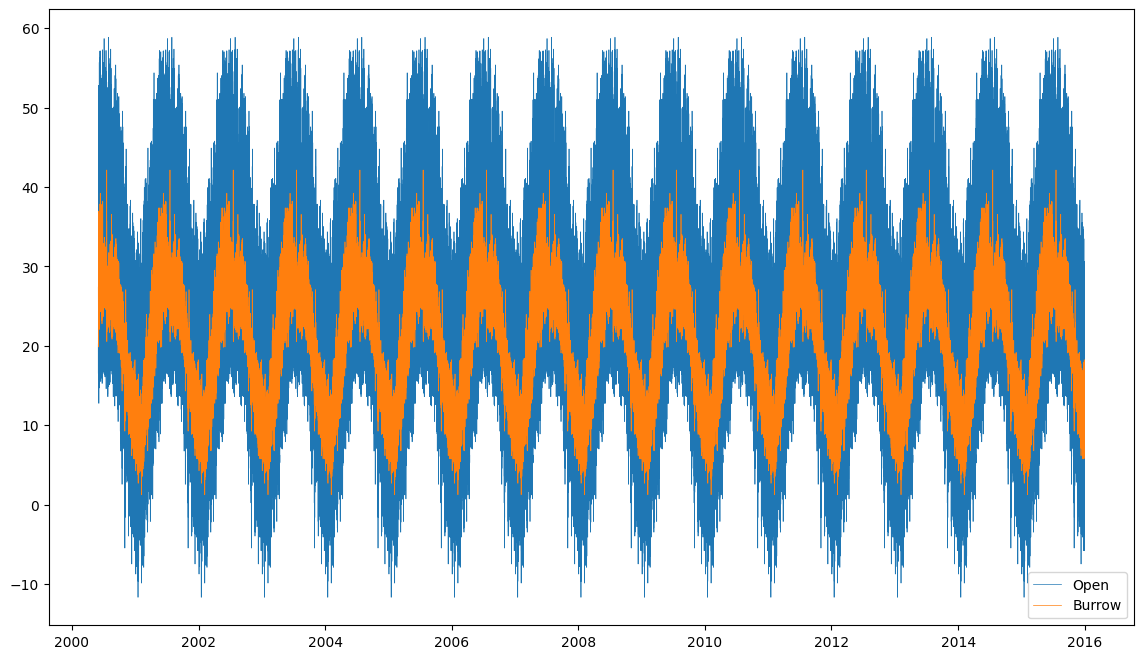

In [19]:
plt.figure(figsize=(14, 8))
# Get the starting year
start_year = model_input['datetime'].dt.year.min()

# Keep rows within the first 5 years
filtered_input = model_input[model_input['datetime'].dt.year < start_year + 16]
plt.plot(filtered_input['datetime'], filtered_input['Open_mean_Temperature'], linewidth=0.5, label='Open')
plt.plot(filtered_input['datetime'], filtered_input['Burrow_mean_Temperature'], linewidth=0.5, label='Burrow')
plt.title
plt.legend()

In [ ]:
# Make Experimental Groups OLD
# appended_data[f'open_plus_1'] = appended_data['Open_mean_Temperature'] + 1
# appended_data[f'burrow_plus_1'] = appended_data['Burrow_mean_Temperature'] + 1
# appended_data[f'open_plus_2'] = appended_data['Open_mean_Temperature'] + 2
# appended_data[f'burrow_plus_2'] = appended_data['Burrow_mean_Temperature'] + 2
# appended_data[f'open_plus_3'] = appended_data['Open_mean_Temperature'] + 3
# appended_data[f'burrow_plus_3'] = appended_data['Burrow_mean_Temperature'] + 3

[Text(0.5, 1.0, 'Open Mean Temp (Canada)')]

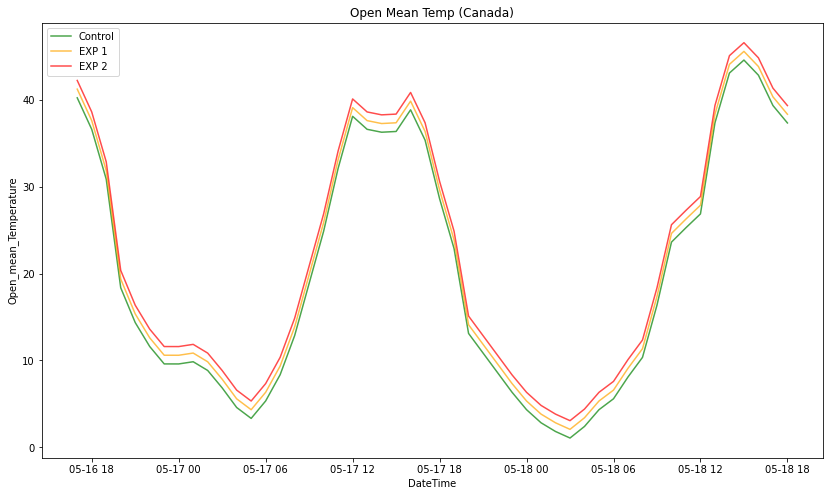

In [65]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='Open_mean_Temperature',
             alpha=0.7,
             color='green',
             label='Control').set(title='Open Mean Temp (Canada)') 
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='open_plus_1',
             color='orange',
             label='EXP 1',
             alpha=0.7).set(title='Open Mean Temp (Canada)')
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='open_plus_2',
             color='red',
             label='EXP 2',
             alpha=0.7).set(title='Open Mean Temp (Canada)') 

In [70]:
# # Drop NA values
# otm_data.dropna(inplace=True)

# Sort the DataFrame by Study_Site and DateTime
appended_data.sort_values(by=['Study_Site', 'DateTime'], inplace=True)

# Save each Study_Site to a separate CSV file
study_sites = appended_data['Study_Site'].unique()
for site in study_sites:
    site_data = appended_data[appended_data['Study_Site'] == site]
    site_data.to_csv(f'Data/{site}_data_{num_years}_years.csv', index=False)